In [1]:
import datetime
import random

import numpy as np
import yaml
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import csv

from utils.FeaturesExtractor import STFTFeaturesExtractor, DWTFeaturesExtractor
from utils.Misc import make_directory
from utils.SoundFileManager import WavFilesManager

## Parameters

In [2]:
yaml_path = "/home/plerolland/Bureau/OHASISBIO_dataset/data/dataset.yaml"

output_path = "/media/plerolland/LaBoite/PublicData/training/classification/spectrograms"

# duration taken before and after the event for the output
delta_output = datetime.timedelta(seconds=50)

# type of data that we want
features_extractor = STFTFeaturesExtractor(None, vmin=-35, vmax=140)  # spectrograms parameters

negatives_per_positive = 2  # number of negative samples that will be taken for each positive one

random.seed(0)

## Initialization

In [3]:
with open(yaml_path, "r") as f:
    params = yaml.load(f, Loader=yaml.BaseLoader)["train_dataset"]
wav_prefix = params["wav_root_dir"]
csv_prefix = params["csv_root_dir"]
studies = params["studies"]
stations = list(params["stations"].keys())

dates = {}
levels = {}
levels_per_study = {}
levels_per_station = {h : [] for h in stations}
managers = {h : WavFilesManager(f"{wav_prefix}/{h}") for h in stations}

make_directory(output_path)
make_directory(f"{output_path}/positives")
make_directory(f"{output_path}/negatives")

## Data loading

In [4]:
for s_name, s in studies.items():
    stations = s["stations"]
    dates[s_name] = {h : [] for h in stations}
    levels[s_name] = {h : [] for h in stations}
    levels_per_study[s_name] = []
    with open(f"{csv_prefix}/{s_name}.csv") as f:
        csv_reader = csv.reader(f, delimiter=",")
        next(csv_reader) # skip first line which contains column names
        lines = list(csv_reader)
    for line in lines:
        station = line[0]
        date = datetime.datetime.strptime(line[1], "%Y%m%d_%H%M%S.%f")
        level = float(line[2])
        dates[s_name][station].append(date)
        levels[s_name][station].append(level)
        levels_per_study[s_name].append(level)
        levels_per_station[station].append(level)

## Plots

Text(0.5, 1.0, 'received levels per study')

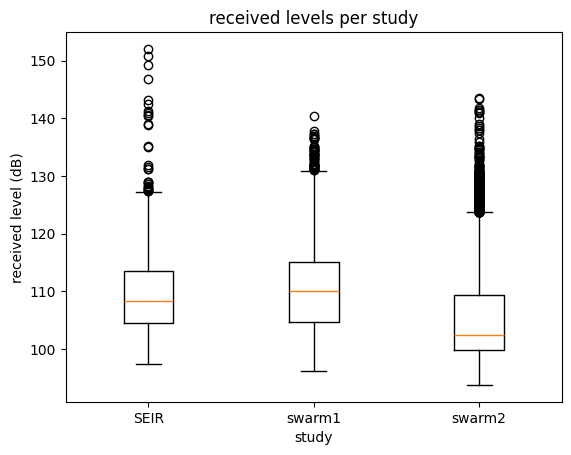

In [5]:
plt.boxplot(list(levels_per_study.values()))
plt.xticks(list(range(1,len(studies)+1)), list(levels_per_study.keys()))
plt.xlabel("study")
plt.ylabel("received level (dB)")
plt.title("received levels per study")

Text(0.5, 1.0, 'received levels per station')

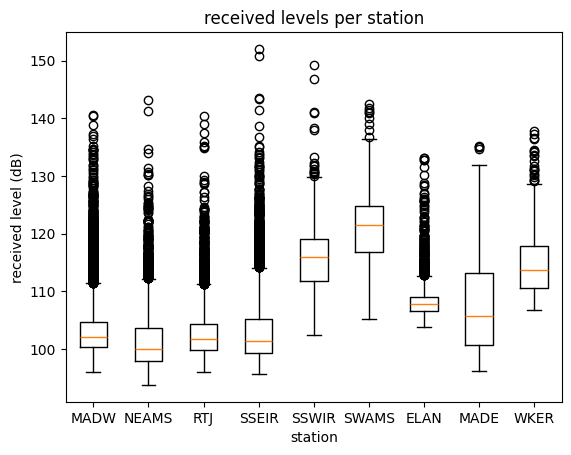

In [6]:
plt.boxplot(list(levels_per_station.values()))
plt.xticks(list(range(1,len(list(levels_per_station.keys()))+1)), list(levels_per_station.keys()))
plt.xlabel("station")
plt.ylabel("received level (dB)")
plt.title("received levels per station")

## Data filtering criterion

In [7]:
min_level = 99.82
levels_merged = np.concatenate(list(levels_per_study.values()))
levels_merged_filtered = levels_merged[levels_merged > min_level]
print(f"Number of picks above level {min_level} dB: {len(levels_merged_filtered)} out of {len(levels_merged)} initial picks ({100*len(levels_merged_filtered)/len(levels_merged):.1f}%)")

Number of picks above level 99.82 dB: 26501 out of 33139 initial picks (80.0%)


## Dataset creation

### Positives

In [8]:
for s_name, s in studies.items():
    print(f"Dealing with study {s_name}")
    make_directory(f"{output_path}/positives/{s_name}")
    for h_name, d in dates[s_name].items():
        make_directory(f"{output_path}/positives/{s_name}/{h_name}")
        features_extractor.manager = managers[h_name]
        for i in tqdm(range(len(d))):
            if levels[s_name][h_name][i] > min_level:
                # we can save it
                offset = (random.random()-0.5) * delta_output
                path = f'{output_path}/positives/{s_name}/{h_name}/{d[i].strftime("%Y%m%d_%H%M%S")}_{offset.total_seconds():.1f}.png'
                if not os.path.isfile(path):
                    features_extractor.save_features(d[i] + offset -delta_output, d[i] + offset +delta_output, path)

Dealing with study SEIR


100%|██████████| 194/194 [00:02<00:00, 92.58it/s] 


Dealing with study swarm1


100%|██████████| 993/993 [00:05<00:00, 198.15it/s]


Dealing with study swarm2


100%|██████████| 4758/4758 [00:24<00:00, 196.25it/s]


### Negatives

In [9]:
for s_name, s in studies.items():
    print(f"Dealing with study {s_name}")
    make_directory(f"{output_path}/negatives/{s_name}")
    
    start_date = datetime.datetime.strptime(params["studies"][s_name]["date_start"], "%Y%m%d_%H%M%S")
    end_date = datetime.datetime.strptime(params["studies"][s_name]["date_end"], "%Y%m%d_%H%M%S")
    duration_s = (end_date - start_date).total_seconds()
        
    for h_name, d in dates[s_name].items():
        make_directory(f"{output_path}/negatives/{s_name}/{h_name}")
        features_extractor.manager = managers[h_name]
        
        d = np.array([(di - start_date).total_seconds() for di in d])
        already_generated = []
        for i in tqdm(range(len(d))):
            if levels[s_name][h_name][i] > min_level:
                # we can save some negatives
                for j in range(negatives_per_positive):
                    # generate random dates until we are far enough from annotations and from previously selected dates
                    while True:
                        res = random.randint(0, duration_s)
                        if np.min(np.abs(res - d)) > 1.5*delta_output.total_seconds():
                            if len(already_generated) == 0 or np.min(np.abs(np.array(already_generated) - res)) > 1.5*delta_output.total_seconds():
                                already_generated.append(res)
                                di = start_date + datetime.timedelta(seconds=res)
                                path = f'{output_path}/negatives/{s_name}/{h_name}/{di.strftime("%Y%m%d_%H%M%S")}.png'
                                features_extractor.save_features(di-delta_output, di+delta_output, path)
                                break

Dealing with study SEIR


100%|██████████| 194/194 [00:04<00:00, 41.80it/s]


Dealing with study swarm1


100%|██████████| 993/993 [00:11<00:00, 86.84it/s] 


Dealing with study swarm2


100%|██████████| 4758/4758 [01:01<00:00, 77.08it/s] 
